# Isomantics_workshop_driver_notebook

# Pipeline  Overview
The Isomantics algorithm consists of the following stages:

## **(Stage 0)** Gather Vocabularies and Training Labels:
* This stage has been pre-completed for the workshop.    
* More details on executing **Stage 0** on your own are located in the cells below. 
    * For full details on how data was prepared see [Michael Seeber's Capstone Report](https://github.com/mike-tamir/IsomanticsWorkshop/blob/master/reports/MichaelSeeber_Isomantics_report_capstone.pdf)


## **(Stage 1)** Embed the Vocabularies:
* This stage has been pre-completed for the workshop with FastText embeddings.  
* More details on executing **Stage 1** on your own are located in the cells below. 
  
## **(Stage 2)** Train translation matrices:
* Training set:
    * For two given languages $Lg_1$ and $Lg_2$, we create a training set $\Omega_{(Lg_1,Lg_2)}$ as follows:
        1. For each $word_i$ in language 1, find the direct translation $\widehat{word_i}$ in language 2.
        2. Find vector embeddings $w_i\in Lg_1$ and $\widehat{w_i}\in Lg_2$ of $word_i$ and $\widehat{word_i}$ respectively.
        3. Add the pair $<w_i,\widehat{w_i}>$ to the training set $\Omega_{(Lg_1,Lg_2)}$
            * **Note** we found that training only for for only the the top 5-10k most popular terms in  $\Omega_{(Lg_1,Lg_2)}$ generates the best word-to-word translation results on out of sample test sets.

### Loss Functions:
###            $$ Loss(T_{Lg_1,Lg_2})= ||Tw_i - \widehat{w_i}||^2_2 $$
###            $$ Loss(T_{Lg_1,Lg_2})= cos(Tw_i,\widehat{w_i}) $$


### Regularization Terms
### $$Reg_{Normality}(T_{Lg_1,Lg_2}) = ||T_{Lg_1,Lg_2}^{T}T_{Lg_1,Lg_2} - T_{Lg_1,Lg_2}T_{Lg_1,Lg_2}^T||_2$$
* _To prevent training singular translation matrices_
### $$Reg_{Frobenius}(T_{Lg_1,Lg_2}) = ||T_{Lg_1,Lg_2}||_2$$
* _To prevent over-fitting_

### Full cost function:
### $$ J(T_{Lg_1,Lg_2})= Loss(T_{Lg_1,Lg_2}) + \lambda_{1}Reg_{Frobenius}(T_{Lg_1,Lg_2}) + \lambda_{2}Reg_{Normality}(T_{Lg_1,Lg_2}) $$  

* Translation matrices have been pre-calculated and are stored in `IsomanticsWorkshop/data/[experiment_name]/T_matrices` as `csv` files.

## **(Stage 3)** SVD and analysis of singular value stats:

* Factor the matrix $T_{Lg_1,Lg_2} = U\Sigma V^T$ where $U$ and $V$ are orthonormal (rotation) matrices and $\Sigma$ gives the singular values (squared spectral values) of $T_{Lg_1,Lg_2}$.
* Pull the statistics of the resulting singular values associated with each pair of languages.
    1. `mean` and `mean_log`
    2. `median` and `median_log`
    3. `std` and `std_log`
    4. `ortho_norm` 
        * Calculates $||T^{T}T-I||_{2}$ *
            * A measure of closeness to the matrix orthogonality of $T_{Lg_1,Lg_2}$
            * The $2$ subscript indicates the Frobenius norm.
         
    5. `condition_num` and `log_condition_num`
        * $n_{c} := \cfrac{\lambda_{max}}{\lambda_{min}}$
            * $\lambda_{max}$ and $\lambda_{min}$ are the largest and smallest singular values respectively
            * Acts as a useful measure of "closeness to singularity" of a matrix
                * High $n_c$ means "ill-conditioned" or "close to singularity" (singular matrices have $n_c = \infty$)
                * Useful in the context of high dimensional matrices (as compared with direct determinants).

## (Stage 4): Plot Heatmaps and Analyze Spectrum Statistics
Plot as a heatmap grid the respective statistics associated with each translation.
* The grid represents the translations from each language (row) to each other language (column).
* Diagonals on the grid correspond to baselines for when a language is translated to itself.

***
***NOTE*** 
* *** Stages 0-2 take a significant amount of processing time.***
* *** These stages can be executed on your own using the following steps.***
* *** For now skip directly to stage 3 ***
***

# (Stage 3): Extract Translation Spectrum Statistics
In Stage 3 we extract the spectra of the translation matrices and find statistical properties of the spectra.

### Executed Stage 3 Steps:
1. Read in all translation matrices generated and exported as csv files in Stage 2
2. Calculate the spectral values and the log of the spectral values for:
    1. the raw translation matrix and/or
    2. the covariance matrix of the translation matrix (optional).
3. Calculate statistical properties of the respective spectra.
4. Export the resulting statistics as a json:
    * Example `../data/dim_300_loss_mse_l2=0_01_normality=0_000001/spec_analysis_stats.json`

Firs lets take a look at the available "Experiments" with translation matrices that have been pre-processed:

In [12]:
# View the available translation hyperparameter experiments
experiments = !ls ../data
print("These are the available already processed experiments:")
i=0
for exp in experiments:
    print("(Experiment %r): \t%s" % (i,exp))
    i+=1

These are the available already processed experiments:
(Experiment 0): 	dim_100_loss_cos_l2_0_0001_normality_0_000001
(Experiment 1): 	dim_100_loss_cos_l2_0_01_normality_0_000001
(Experiment 2): 	dim_100_loss_cos_l2_10_normality_0_000001
(Experiment 3): 	dim_100_loss_cos_l2_1_normality_0_000001
(Experiment 4): 	dim_100_loss_mse_l2_0_001_normality_0_000001
(Experiment 5): 	dim_100_loss_mse_l2_0_01_normality_0_000001
(Experiment 6): 	dim_100_loss_mse_l2_10_normality_0_000001
(Experiment 7): 	dim_100_loss_mse_l2_1_normality_0_000001
(Experiment 8): 	dim_300_loss_cos_l2_0_001_normality_0_000001
(Experiment 9): 	dim_300_loss_cos_l2_0_01_normality_0_000001
(Experiment 10): 	dim_300_loss_cos_l2_10_normality_0_000001
(Experiment 11): 	dim_300_loss_cos_l2_1_normality_0_000001
(Experiment 12): 	dim_300_loss_mse_l2_0_001_normality_0_000001
(Experiment 13): 	dim_300_loss_mse_l2_0_01_normality_0_000001
(Experiment 14): 	dim_300_loss_mse_l2_10_normality_0_000001
(Experiment 15): 	dim_300_loss_mse_l2

Stage 3 is fully executed by running the following python script 
* `execute_spectral_analysis.py`
* The `$experiment` argument specifies the experiment in `../data` with the `T_matrices` csv files exported in stage 2.

In [10]:
# specify which experiment in the list to run analysis on
# you can change the index in the list experiments[1] to run analysis on a different experiment
experiment = experiments[0]
print("Calculating Spectrum statistics for the translation matrix from experiment:\n"+experiment+"\n")

# Run analysis with the execute_spectral_analysis.py script
!python execute_spectral_analysis.py $experiment

Calculating Spectrum statistics for the translation matrix from experiment:
100_cosine_proximity_l2_0_0001_normality_0_000001

Using TensorFlow backend.
Translation Spectra Analyzed writing json to the following path:
../data/100_cosine_proximity_l2_0_0001_normality_0_000001/spec_analysis_stats.json


# (Stage 4): Plot Heatmaps and Analyze Spectrum Statistics

### Executed Stage 4 Steps:
1. Read in the json containing the statistical properties of the spectra calculated in stage 3, 
2. Plot as a heatmap grid the respective statistics associated with each translation.
    * The grid represents the translations from each language (row) to each other language (column).
    * Diagonals on the grid correspond to baselines for when a language is translated to itself.
    * Each heatmap is generated from 
        * a matrix type (translation matrix or its covariance matrix), and
        * a different selected statistic.
    
Stage 4 can be executed in the below cell with the following two functions from `ismtools`:
* `read_json` to read the json stats back in as the `T_matrix_dict`
* `plot_heatmaps` select which heatmaps you want to generate


mean of the translation matrix spectrum


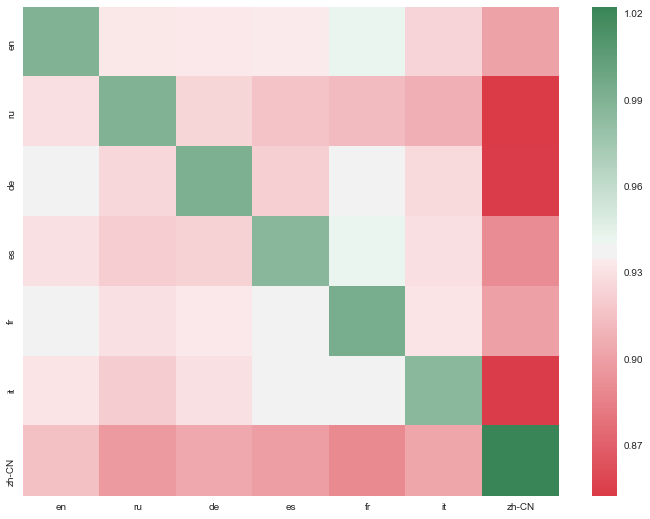

median of the translation matrix spectrum


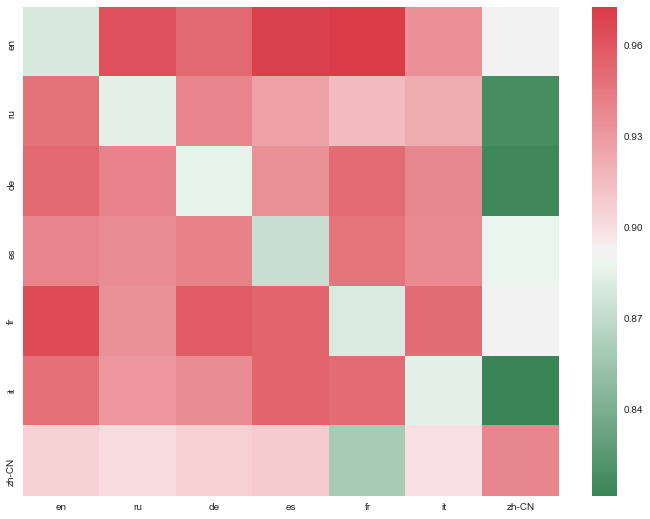

std of the translation matrix spectrum


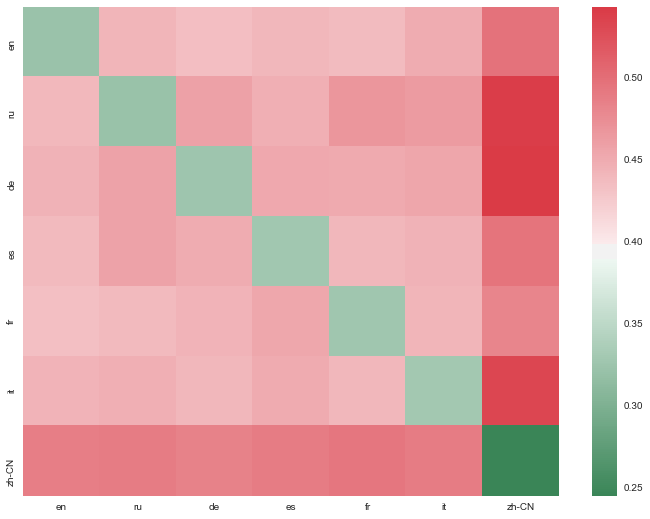

mean_log of the translation matrix spectrum


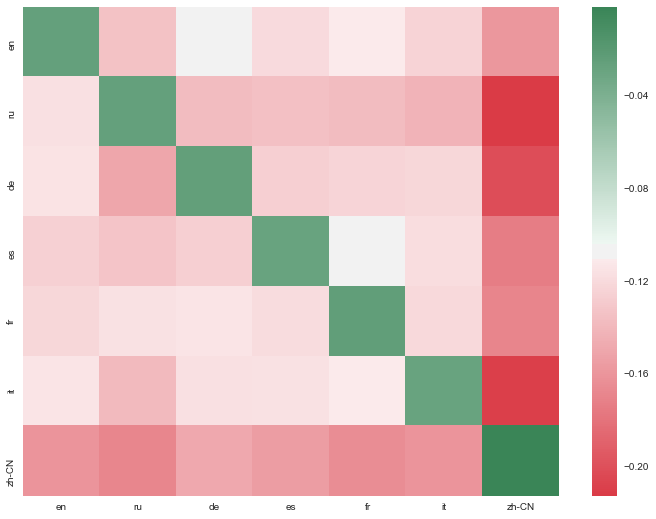

median_log of the translation matrix spectrum


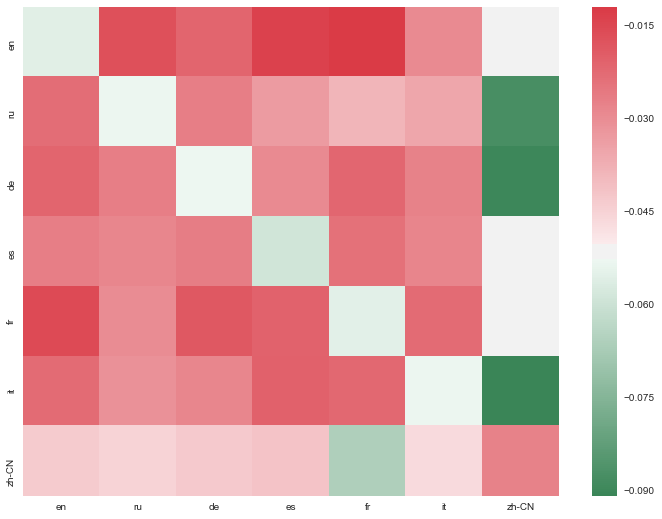

std_log of the translation matrix spectrum


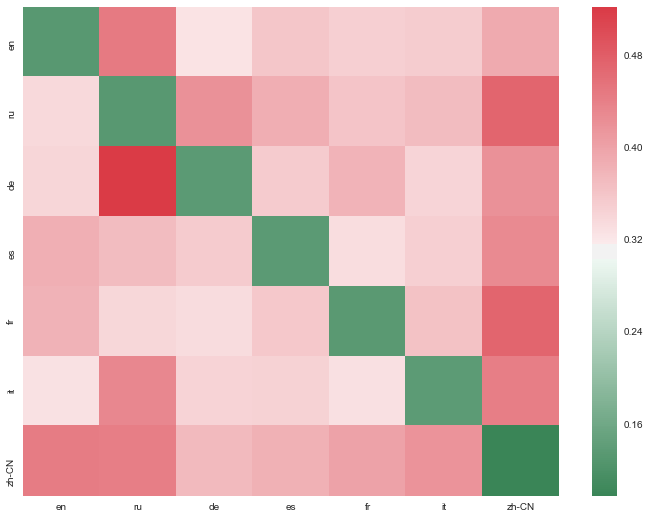

ortho_norm of the translation matrix spectrum


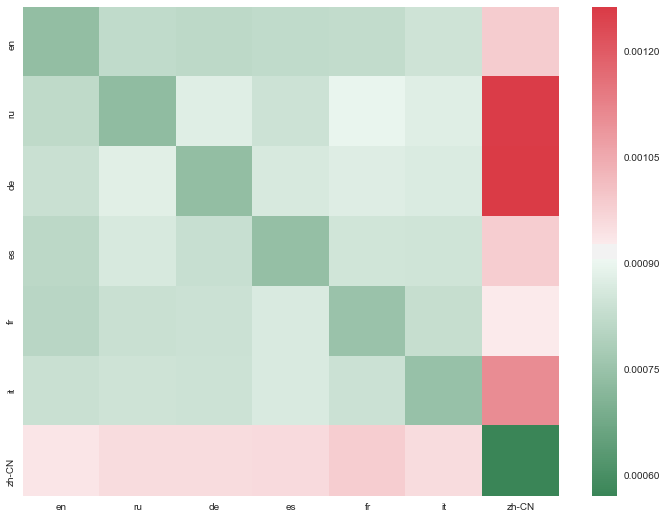

condition_num of the translation matrix spectrum


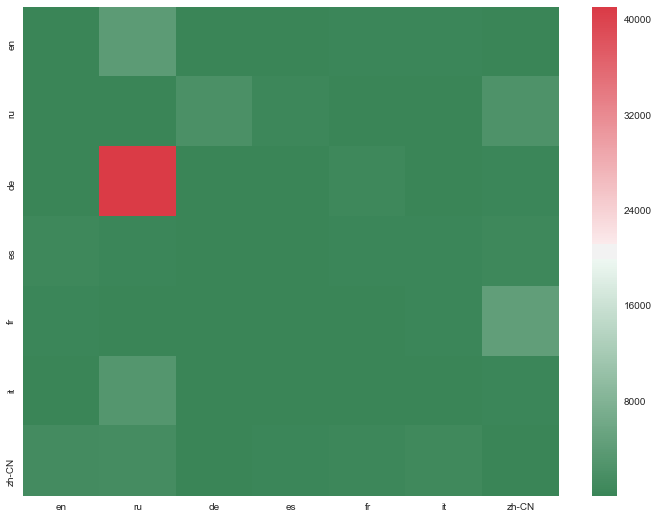

log_condition_num of the translation matrix spectrum


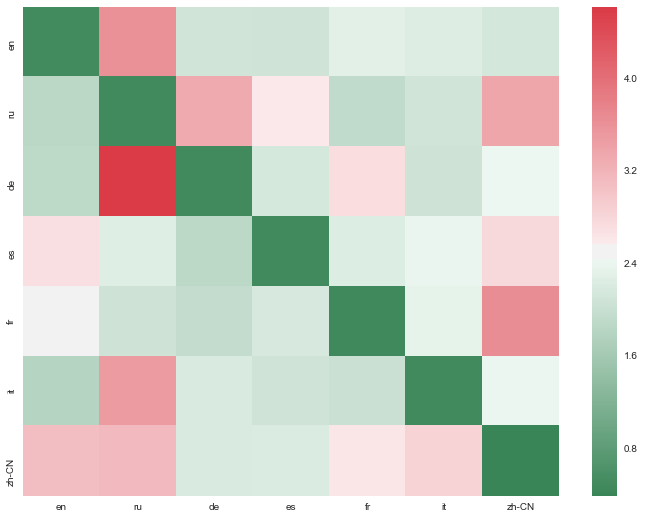

mean of the translation covariance matrix spectrum


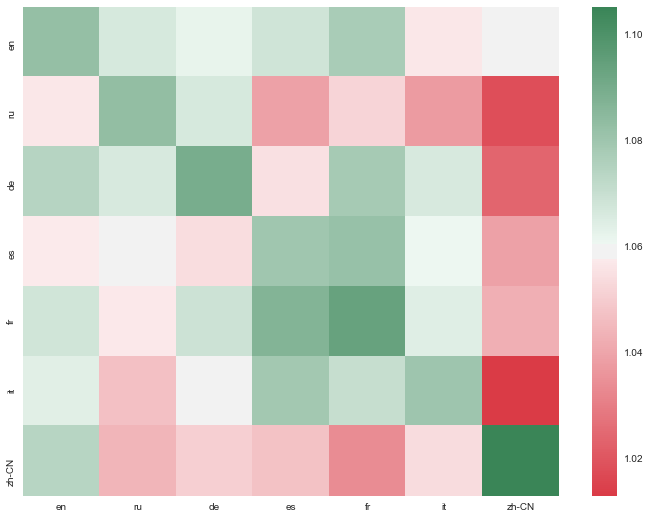

median of the translation covariance matrix spectrum


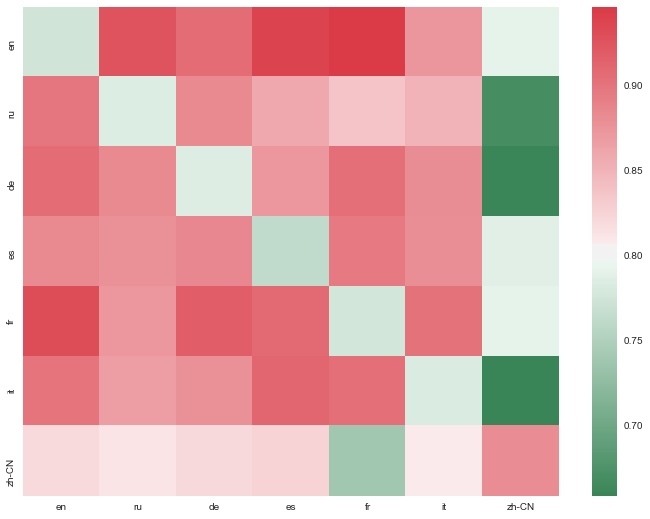

std of the translation covariance matrix spectrum


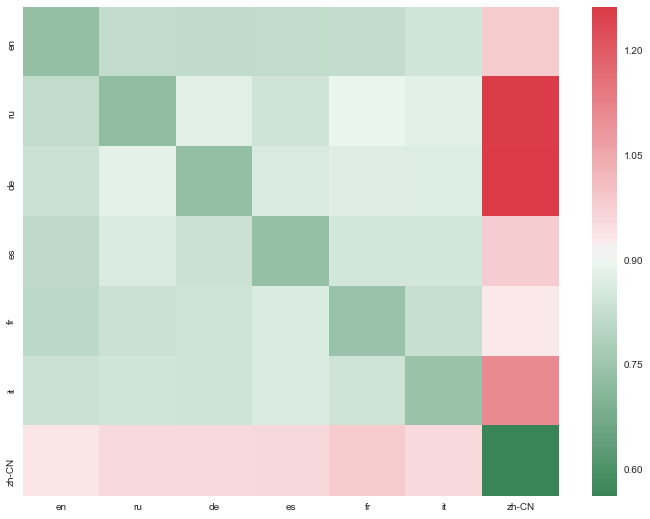

mean_log of the translation covariance matrix spectrum


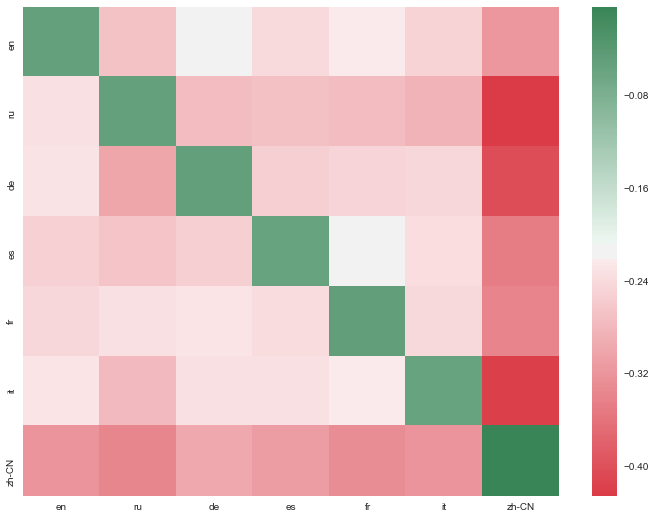

median_log of the translation covariance matrix spectrum


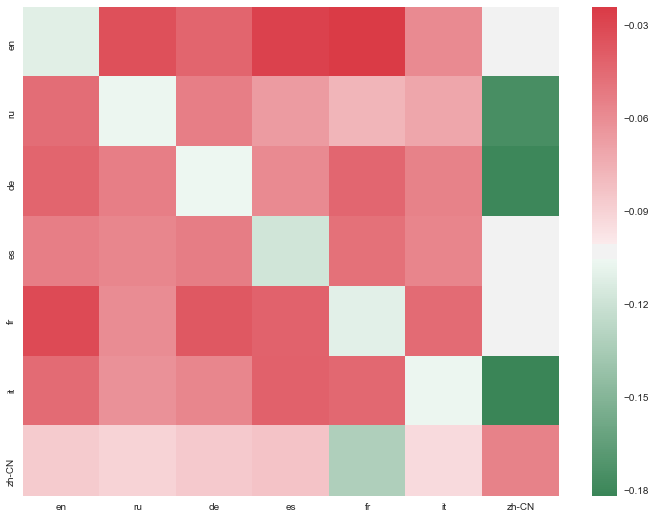

std_log of the translation covariance matrix spectrum


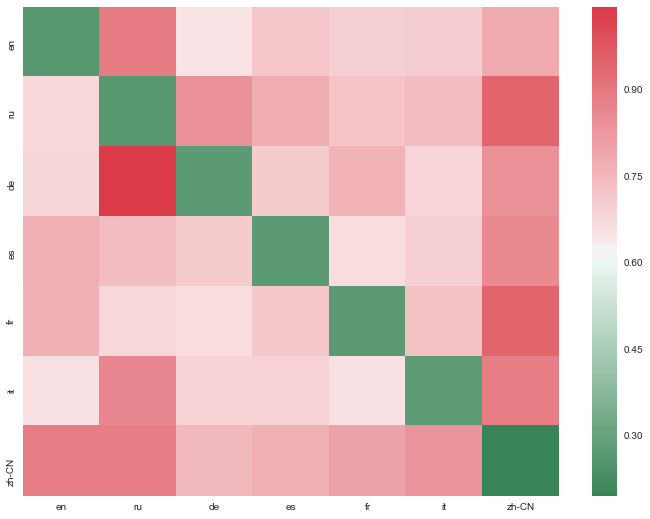

ortho_norm of the translation covariance matrix spectrum


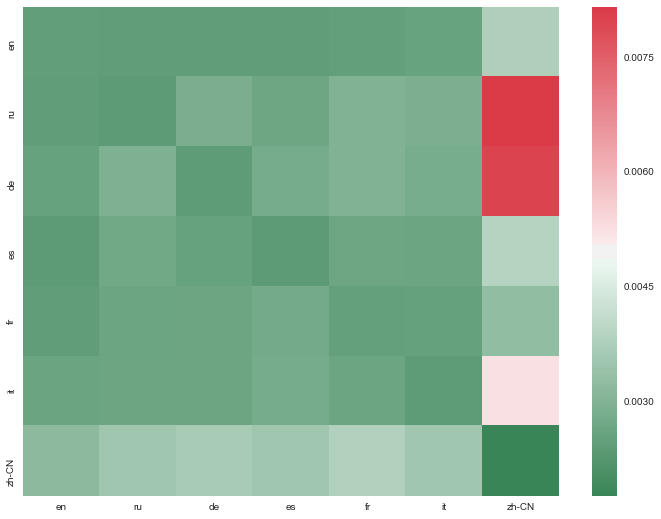

condition_num of the translation covariance matrix spectrum


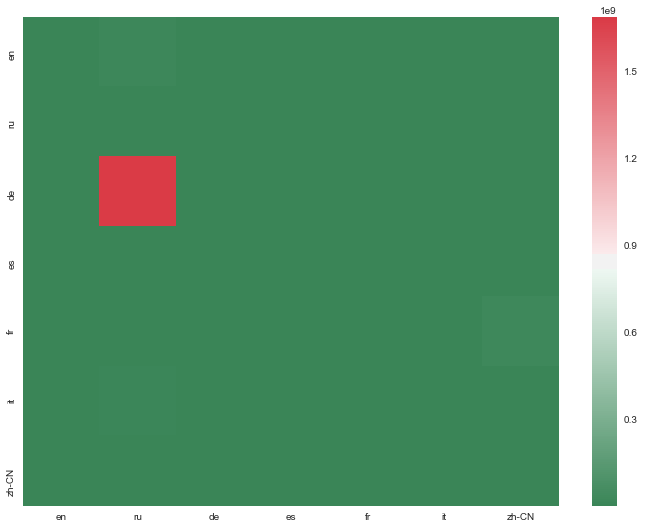

log_condition_num of the translation covariance matrix spectrum


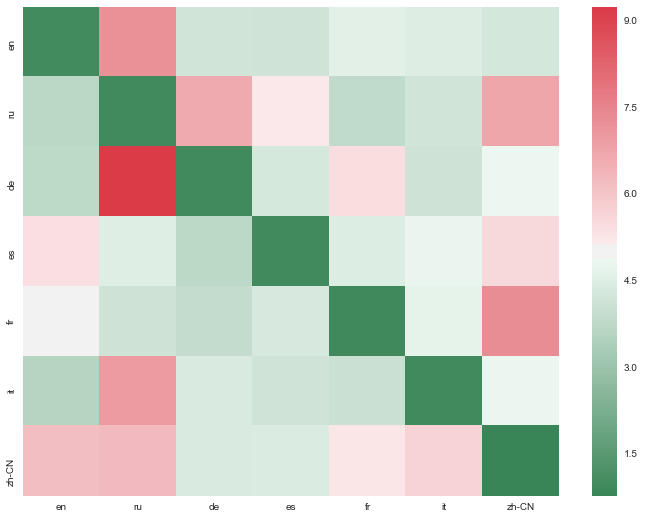

In [13]:
from ismtools import read_json, plot_heatmaps
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Construct the JSON path based on the experiment chosen in stage 3
experiment = experiments[0]
PATH = "../data/"+experiment
MATRIX_TYPES = [
                "T_matrix",
                "T_cov"
               ]
STATS = [
         'mean', 
         'median', 
         'std', 
         'mean_log', 
         'median_log', 
         'std_log', 
         'ortho_norm',
         'condition_num',
         'log_condition_num'
        ]


heatmaps = plot_heatmaps(T_matrix_dict=read_json(PATH+"/spec_analysis_stats.json"),
                         plotted_stats=STATS,
                         display_opt="cols",
                         matrix_types=MATRIX_TYPES,
                         low_c=10,
                         high_c=140,
                         sep_num=8,
                         figuresize=[12,9],
                         write_heatmaps=PATH
                        )

# Executing Stages (0-2) independently:

## Executing Stage 0: 
### Download the files required for Isomantics.
These steps are used to:

  1. Authenticate the Google Drive API for translating words from one language to another. 
  2. Create vocabulary and corresponding vectors pickle files for each language. 
  3. Translate one language vocab to another and create pickle files for `lg1`-> `lg2` translations. 
  (e.g. `en_en.pkl`, `en_ru.pkl`...). 
  
**Note: For the ease of running experiments and testing, pickle files for vocabs, vectors and translations have already been created.**
To Download the Pre-Trained FastText Embeddings:
* Go to [facebookresearch/fasttext](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)
* Click on the *[text]()* link corresponding to the language and save `.vec` file to `/code/fasttext` directory.

</br>
**OR**
</br>

* Vectors can be downloaded from the following links too.
  * [English](https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec)
  * [Russian](https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.ru.vec)
  * [German](https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.de.vec)
  * [French](https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec)
  * [Italian](https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.it.vec)
  * [Chinese](https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.zh.vec)
          
</br>   

* Download the pickled translations from [pickled translations](https://mega.nz/#!wkRlQAAQ!bkqHMKfreAgo8jVJQywoAWOxjXHfM63WbfNx3nYHnQ4) link, save and unzip the folder in the root directory. (Don't change the name of the unzipped folder)  
***

## Stage 1:
**1. If you've chosen to download the vectors, do the following steps to create your own .pkl translation files, if not go to 2.:**

1. To authenticate the gdrive API:
    * Go to [Google Drive API Guide](https://developers.google.com/drive/v3/web/quickstart/python) and follow the step 1 to turn on the gdrive API for your project.
    * **Note**: Download the json file in step **h)** and name it as `client_secrets.json` in the root directory.
2. Change directory to the `/code` and run the following command on the terminal to create a `gauth.yml` file:
`$ python3 gauth.py`
    
3. Run **vocab_vectors.py** to pickle the vocab and vector objects.
`$ python3 vocab_vectors.py`

4. Run **build_translations.py** to create pickle translations for English to English.
`$ python3 build_translations.py en en

5. Open a new tab in the terminal and run the translations code for a new translation for (e.g.) English to Spanish.
`$ python3 build_translations.py en es`
    * Repeat for all other language combinations.

</br>
***

## (Stage 2) 

### Train translation matrices:

 * The vocab and the vector embeddings are located in the created `IsomanticsWorkshop/pickle` dir.
 * Change directory to `IsomanticsWorkshop/code/` to train the translation matrices.
 * The following code trains the translation matrices and exports the `.csv` files to the specified experiment folder in `IsomanticsWorkshop/data/`
 * Run the following code with appropriate flags

In [ ]:
# specify name of the experiment with '--e' flag: 
# specify the name of the model regularizer with '--m' flag
# possible values for model regularizers: 'l2', 'l3_l2', 'l3'
! python3 isomantics_train_translations.py --exp_name 100_cosine_proximity_l2_0_0001_normality_0_000001 --reg_name normality_l2 --loss_func cosine_proximity --dim 100 --l2_lambda 0.0001 --normality_lambda 0.000001